In [ ]:
import keras
from keras import layers

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [ ]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [ ]:
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 50500       input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          51152       encoder[0][2]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           50240       input_1[0][0]                    
____________________________________________________________________________________________

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=10,
        batch_size=32,
        validation_data=(x_test, x_test))

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/10
1875/1875 [==============================] - 18s 3ms/step - loss: 218.9953 - val_loss: 168.4882
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 167.8475 - val_loss: 164.0689
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 163.7460 - val_loss: 161.3256
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 161.2159 - val_loss: 159.8065
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 159.6119 - val_loss: 158.4356
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 158.4122 - val_loss: 157.7415
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 157.7362 - val_loss: 156.8120
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 156.6865 - val_loss: 156.0001
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 155.9749 -

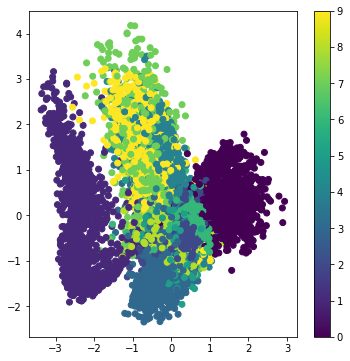

In [ ]:
import matplotlib.pyplot as plt 
x_test_encoded = encoder.predict(x_test, batch_size=32)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0][:,0], x_test_encoded[0][:,1], c=y_test)
plt.colorbar()
plt.show()

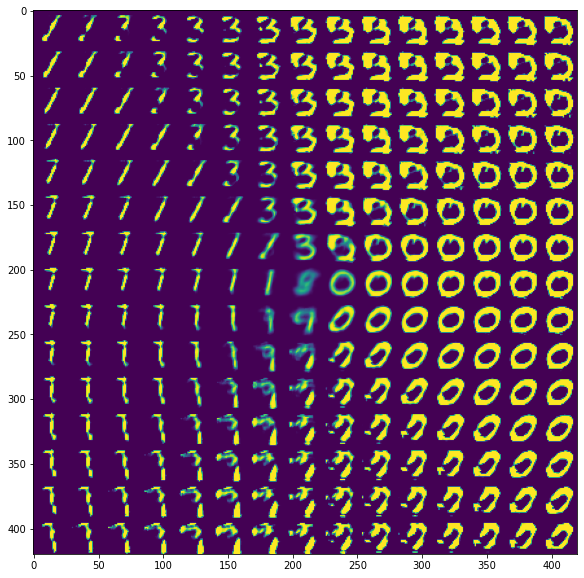

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [16]:
len(y_test)

10000

In [67]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [ ]:
x_train.shape

(60000, 784)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import h5py
import numpy as np

In [ ]:
!pip install obspy

In [28]:
import obspy
import h5py
from obspy import UTCDateTime
import numpy as np
from obspy.clients.fdsn.client import Client
import matplotlib.pyplot as plt

In [29]:
def make_stream(dataset):
    '''
    input: hdf5 dataset
    output: obspy stream

    '''
    data = np.array(dataset)

    tr_E = obspy.Trace(data=data[:, 0])
    tr_E.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_E.stats.delta = 0.01
    tr_E.stats.channel = dataset.attrs['receiver_type']+'E'
    tr_E.stats.station = dataset.attrs['receiver_code']
    tr_E.stats.network = dataset.attrs['network_code']

    tr_N = obspy.Trace(data=data[:, 1])
    tr_N.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_N.stats.delta = 0.01
    tr_N.stats.channel = dataset.attrs['receiver_type']+'N'
    tr_N.stats.station = dataset.attrs['receiver_code']
    tr_N.stats.network = dataset.attrs['network_code']

    tr_Z = obspy.Trace(data=data[:, 2])
    tr_Z.stats.starttime = UTCDateTime(dataset.attrs['trace_start_time'])
    tr_Z.stats.delta = 0.01
    tr_Z.stats.channel = dataset.attrs['receiver_type']+'Z'
    tr_Z.stats.station = dataset.attrs['receiver_code']
    tr_Z.stats.network = dataset.attrs['network_code']

    stream = obspy.Stream([tr_E, tr_N, tr_Z])

    return stream

In [30]:
import pandas as pd
import numpy as np
def getSamples(fileName, setStart, setEnd, startIndex, endIndex):
  # fileName: like 'drive/Shareddrives/anomalyResearch/chunk1/chunk1.hdf5'
  # setStart: start index of dataset chosen
  # setEnd: end index of dataset chosen
  # startIndex: start position of choosen slide window
  # endIndex: end position of choosen slide window
  file_name = fileName
  dtf1 = h5py.File(file_name,'r')
  data_group = dtf1["data"]

  data_keys = list(data_group.keys())
  fileList = data_keys[setStart:setEnd]

  sample_list = []
  #time_list = []
  for i in range(len(fileList)):
     sub_name = "data/" + fileList[i] + ""
     #print(sub_name)
     dataset = dtf1.get(sub_name)
     st = make_stream(dataset)
     #print(max(st[2]))
     st_list = list(st[2][startIndex:endIndex])
     sample_list.extend(st_list)
     #timestart = fileList[i][8:12] + "-" + fileList[i][12:14] + "-" + fileList[i][14:16] + " " + fileList[i][16:18] + ":" + fileList[i][18:20] + ":00" 
     #print(timestart)
     #time1 = np.datetime64(timestart, 'ms')
     #timeStamp = pd.date_range(time1, freq='10L', periods=6000).strftime("%Y-%m-%d %H:%M:%S").tolist()
     #time_list.extend(timeStamp[startIndex:endIndex])

  return sample_list

In [31]:
fileName = 'drive/Shareddrives/anomalyResearch/chunk1/chunk1.hdf5'

noise_train = getSamples(fileName=fileName, setStart=0, setEnd=30000, startIndex=500, endIndex=2500)

In [32]:
fileName = 'drive/Shareddrives/anomalyResearch/chunk1/chunk1.hdf5'

noise_test = getSamples(fileName=fileName, setStart=30001, setEnd=35001, startIndex=500, endIndex=2500)

In [33]:
fileName = 'drive/Shareddrives/anomalyResearch/chunk3/chunk3.hdf5'

earth_train = getSamples(fileName=fileName, setStart=0, setEnd=30000, startIndex=500, endIndex=2500)

In [44]:
fileName = 'drive/Shareddrives/anomalyResearch/chunk3/chunk3.hdf5'

earth_test = getSamples(fileName=fileName, setStart=30001, setEnd=35001, startIndex=500, endIndex=2500)

In [35]:
x_train = noise_train + earth_train

In [37]:
x_train1 = np.array(x_train)

In [40]:
x_train1 = x_train1.reshape(60000,2000)

In [45]:
x_test = noise_test + earth_test

In [46]:
x_test1 = np.array(x_test)

In [47]:
x_test1 = x_test1.reshape(10000,2000)

In [48]:
original_dim = 2000
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [49]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [50]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')


In [51]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [62]:
x_train = x_train1.astype('float32') / 255.
x_test = x_test1.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 8s 17ms/step - loss: nan - val_loss: nan
Epoch 2/50
469/469 [==============================] - 8s 17ms/step - loss: nan - val_loss: nan
Epoch 3/50
469/469 [==============================] - 8s 16ms/step - loss: nan - val_loss: nan
Epoch 4/50
469/469 [==============================] - 8s 16ms/step - loss: nan - val_loss: nan
Epoch 5/50
469/469 [==============================] - 8s 16ms/step - loss: nan - val_loss: nan
Epoch 6/50
469/469 [==============================] - 8s 16ms/step - loss: nan - val_loss: nan
Epoch 7/50
469/469 [==============================] - 8s 16ms/step - loss: nan - val_loss: nan
Epoch 8/50
469/469 [==============================] - 8s 16ms/step - loss: nan - val_loss: nan
Epoch 9/50
469/469 [==============================] - 8s 16ms/step - loss: nan - val_loss: nan
Epoch 10/50
469/469 [==============================] - 8s 17ms/step - loss: nan - val_loss: nan
Epoch 11/50
469/469 [============================

In [53]:
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2000)]       0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 128324      input_2[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 2000)         130192      encoder[0][2]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           128064      input_2[0][0]                    
____________________________________________________________________________________________

In [63]:
train_y0 = [0] * 30000
train_y1 = [1] * 30000
train_y = train_y0 + train_y1
train_y = np.array(train_y)
train_y

array([0, 0, 0, ..., 1, 1, 1])

In [64]:
test_y0 = [0] * 5000
test_y1 = [1] * 5000
test_y = test_y0 + test_y1
test_y = np.array(test_y)
test_y

array([0, 0, 0, ..., 1, 1, 1])

In [66]:
len(test_y)

10000

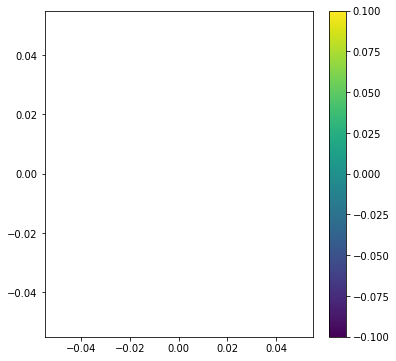

In [65]:
import matplotlib.pyplot as plt 
x_test_encoded = encoder.predict(x_test, batch_size=32)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0][:,0], x_test_encoded[0][:,1], c=test_y)
plt.colorbar()
plt.show()

In [56]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(40, 50)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

ValueError: ignored